In [5]:
from time import time
import logging
import pylab as pl
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
from PIL import Image
import numpy as np

In [6]:
# Display progress logs on stdout
logging.basicConfig(level = logging.INFO, format = '%(asctime)s %(message)s')

In [7]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

2017-02-22 20:38:43,140 Loading LFW people faces from /Users/hujie/scikit_learn_data/lfw_home


In [8]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

In [9]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [10]:
print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [12]:
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])

Extracting the top 150 eigenfaces from 966 faces


In [13]:
t0 = time()
pca = RandomizedPCA(n_components = n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

/Users/hujie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.236s


In [20]:
pca.explained_variance_ratio_

array([ 0.19346364,  0.15116846,  0.07083635,  0.05952002,  0.05157537,
        0.02887196,  0.02514492,  0.02176449,  0.02019351,  0.01902112,
        0.01682188,  0.0158062 ,  0.01223357,  0.01087942,  0.01064441,
        0.00979658,  0.0089241 ,  0.00854849,  0.00835738,  0.00722656,
        0.00696581,  0.00653869,  0.0063956 ,  0.00561311,  0.00531102,
        0.00520162,  0.00507468,  0.00484212,  0.00443594,  0.00417819,
        0.00393691,  0.00381729,  0.00356074,  0.00351185,  0.00334553,
        0.00329934,  0.00314633,  0.0029621 ,  0.0029012 ,  0.00284701,
        0.00279981,  0.00267537,  0.00259886,  0.00258371,  0.0024091 ,
        0.00238975,  0.0023541 ,  0.00222564,  0.00217484,  0.00216545,
        0.00209046,  0.00205389,  0.002004  ,  0.00197355,  0.00193807,
        0.00188737,  0.00180135,  0.0017885 ,  0.0017478 ,  0.0017299 ,
        0.00165611,  0.00162869,  0.00157354,  0.00153348,  0.00149849,
        0.00147189,  0.00143851,  0.00141763,  0.00139614,  0.00

In [14]:
eigenfaces = pca.components_.reshape((n_components, h, w))
print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Projecting the input data on the eigenfaces orthonormal basis
done in 0.023s


In [15]:
# SVM training
t0 = time()
param_grid = {
    'C': [1e3,5e3,1e4,5e4,1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='auto'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

/Users/hujie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/hujie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/hujie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/hujie/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarn

done in 16.434s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [16]:
print "Predicting the people names on testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names = target_names)
print confusion_matrix(y_test, y_pred, labels = range(n_classes))

Predicting the people names on testing set
done in 0.045s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.75      0.87      0.81        60
  Donald Rumsfeld       0.84      0.78      0.81        27
    George W Bush       0.88      0.89      0.89       146
Gerhard Schroeder       0.78      0.84      0.81        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.93      0.69      0.79        36

      avg / total       0.83      0.83      0.83       322

[[  9   1   2   1   0   0   0]
 [  2  52   0   5   0   1   0]
 [  4   1  21   1   0   0   0]
 [  2   9   1 130   2   1   1]
 [  0   2   0   2  21   0   0]
 [  0   2   0   1   3   8   1]
 [  0   2   1   7   1   0  25]]


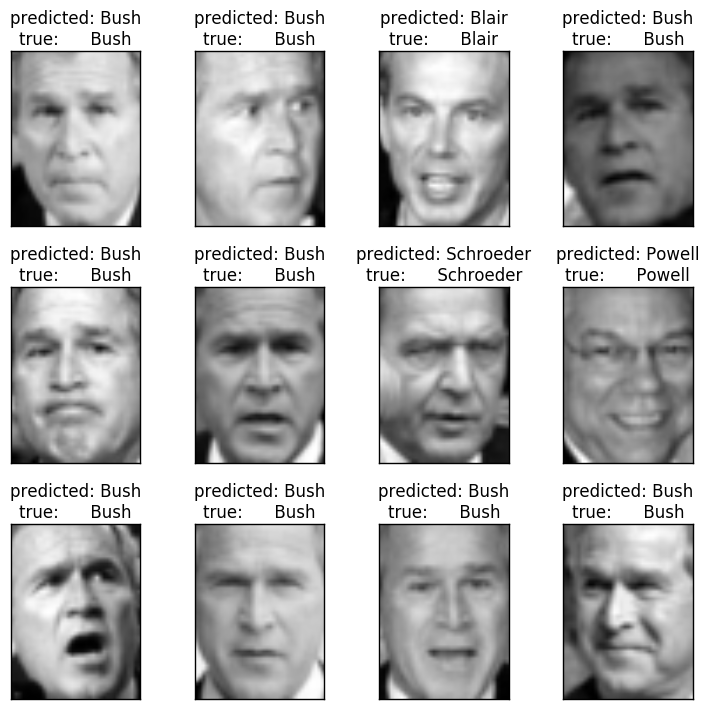

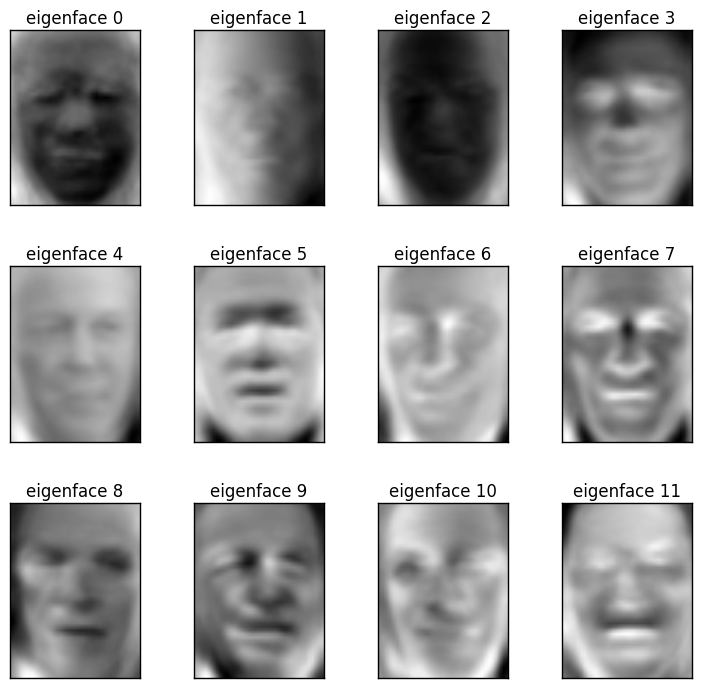

In [17]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()